In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry
# from agents import run_episode
import joblib

In [10]:
from models.utils import fetch_data
data = fetch_data(1)

Excluding 9 out of 60 partipicants


In [67]:
from models.utils import make_env
env = make_env(0, 5, )

In [81]:
from models.classical import DepthFirstModel
model = next(DepthFirstModel.all_models(env))
model

DepthFirstModel(satisfice=None, prune=None)

In [96]:
pd.DataFrame({'x': 1, 'y': 2})

ValueError: If using all scalar values, you must pass an index

In [100]:
import os
pd.DataFrame(list(map(pd.read_pickle, glob('results/mle/*'))))

,logp,p_error,temp,model,satisfice,prune
0,-18232.577397,0.25,10.0,DepthFirstModel,4.0,-16.0
1,-18232.577397,0.25,10.0,DepthFirstModel,4.0,-20.0
2,-18242.619152,0.25,10.0,DepthFirstModel,4.0,-24.0


In [82]:
from fit_model import fit
fit(model, data['unrolled'])

AssertionError: 

{'satisfice': [2.0,
  4.0,
  6.0,
  8.0,
  10.0,
  12.0,
  14.0,
  16.0,
  18.0,
  20.0,
  22.0,
  24.0,
  26.0,
  28.0,
  30.0,
  32.0,
  34.0,
  36.0,
  38.0,
  40.0,
  42.0,
  44.0,
  46.0,
  48.0,
  50.0,
  52.0,
  54.0,
  56.0,
  58.0,
  60.0],
 'prune': [-60.0,
  -58.0,
  -56.0,
  -54.0,
  -52.0,
  -50.0,
  -48.0,
  -46.0,
  -44.0,
  -42.0,
  -40.0,
  -38.0,
  -36.0,
  -34.0,
  -32.0,
  -30.0,
  -28.0,
  -26.0,
  -24.0,
  -22.0,
  -20.0,
  -18.0,
  -16.0,
  -14.0,
  -12.0,
  -10.0,
  -8.0,
  -6.0,
  -4.0,
  -2.0]}

In [2]:
EXPERIMENT = 1
envs = {f'{cost:.1f}': make_env(mu=0, sigma=5, cost=cost, ground_truth=False)
        for cost in np.arange(0.4, 2.01, 0.1)}

In [7]:
env = make_env(9, 4)
env.expected_term_reward(make_env(3, 1).init)

9.0

In [ ]:
%%time
# Qs = {}
for c, env in envs.items():
    if c not in Qs:
        Q, V, pi, info = solve(env)
        Qs[c] = Q
        print(c, V(env.init))

0.5 11.8857321143


# Alternative models

## Satisficing and pruning

In [88]:
from functools import wraps

def observed(state, node):
    return not hasattr(state[node], 'sample')

def satisfruning(preference, env=env):
    @wraps(preference)
    @curry
    def new_pref(state, action, prune, satisfice):
        if action == env.term_action:
            if satisfice is not None:
                satisfied = env.expected_term_reward(state) >= satisfice
                return 1e10 if satisfied else -1e10
        elif prune is not None:
            if env.node_quality(action, state).expectation() <= prune:
                return -1e20
        return preference(state, action)
    
    return new_pref

## Preferences

In [89]:
@satisfruning
def depth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are further from the start
    return len(previous_nodes)

@satisfruning
def breadth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are closer to the start
    return -len(previous_nodes)

@satisfruning
def best_first(state, action):
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

@satisfruning
def backward_best_first(state, action):
    children = env.tree[action]
    if children and not any(observed(state, node) for node in children):
        return -1e10
    q = env.node_quality(action, state)
    return q.expectation()

@satisfruning
def progressive_deepening(state, action,  last_click=None):
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    if last_click:
        # version if last_click is available
        if last_clicka in env.leaves():
            if len(previous_nodes) == 1:
                # the start of a new path = another leaf on the previous path
                return len(env.path_to(last_click)[:-1])
            return len(previous_nodes)
        if last_click == previous_nodes[-1]:
            return 1e10
        return len(previous_nodes)
    else:
        # the following only works for a 3-1-2 environment
        if action in env.leaves():
            leaf_group = None
            for subtree in env.tree:
                if (len(subtree) == 2) and (action in subtree):
                    leaf_group = subtree
            for leaf in leaf_group:
                if observed(state, leaf):
                    return 1 # set same value as the beginning of a new path
        return len(previous_nodes)

@curry
def biased_optimal(state, action, cost, **kwargs):
    return Qs[cost](state, action)


# Model human data

In [10]:
df = data['unrolled'].query('pid == 1')

In [14]:
from error_model import ErrorModel
from classical import *

## Parameters to search over

In [16]:
env = make_env(mu=0, sigma=5, cost=1, ground_truth=False)
path_values = env.term_reward().vals
error = {
    'p_error': np.linspace(0.01,0.25, 25),
    'temp': np.logspace(-5,1, 50),
}
satprun = {
    'satisfice': [v for v in path_values if v > 0],
    'prune': [v for v in path_values if v < 0],
}
models = {
    'depth_first': {
        **error,
        **satprun,
        'pref': depth_first,  
        # 'temp': [1e-10]
    },
    'breadth_first': {
        **error,
        **satprun,
        'pref': breadth_first,
        # 'temp': [1e-10]
    },
    'progressive_deepening': {
        **error,
        **satprun,
        'pref': progressive_deepening,
        # 'temp': [1e-10]
    },
    'best_first': {
        **error,
        **satprun,
        'pref': best_first,
    },
    'backward_best_first': {
        **error,
        **satprun,
        'pref': backward_best_first,
    },
#     'optimal': {
#         **error,
#         'pref': biased_optimal,
#         'cost': ['1.0']
#     },
#     'biased_optimal': {
#         **error,
#         'pref': biased_optimal,
#         'cost': list(Qs.keys()),
#     },
#     'no_click': {
#         **error,
#         'temp': [1e-10],
#         'pref': satisfruning(lambda s, a: 0),
#         'satisfice': [-1e10],
#         'prune': [None],
#     },
    # 'random': {
    #     'pref': lambda s, a: 0,
    #     'p_error': [1],
    #     'temp': [1e-10]
    # },
#     'satisfruning_optimal': {
#         **defaults,
#         'pref': Q,
#     },
#     'satisfruning_random': {
#         **defaults,
#         'pref': lambda s, a: 0,
#         'temp': [1e-10]
#     },
}

In [42]:
from error_model import ErrorModel
model = ErrorModel(env, best_first(prune=-10, satisfice=10), df)
model.maximum_likelihood_estimate(**error)

{'logp': 30.683226397100306, 'temp': 10.0, 'p_error': 0.01}

# Find MLE

4

In [177]:
def best_logp(df, n=1, group=None):
    if group:
        return df.groupby(group).apply(lambda d: d.nlargest(n, 'logp')).reset_index(drop=True)
    else: 
        return df.nlargest(n, 'logp')

def maximum_likelihood(data, pref, temp, p_error,
                       n_keep_temp_error=1, n_keep_sat_prn=1,
                       **params):
    choices = []
    for prm in dict_product(params):
        prm_pref = pref(**prm)
        model = MouselabModel(env, prm_pref, data)
        logp = np.log(model.likelihood(temp=temp, p_error=p_error))
        total_logp = logp.sum(0)  # sum logp for each state/action
        
        idx = pd.MultiIndex.from_product([temp, p_error], names=['temp', 'p_error'])
        grid = pd.Series(total_logp.flat, index=idx, name='logp').reset_index()
        for k, v in prm.items():
            grid[k] = v
        choices.append(best_logp(grid, n_keep_temp_error))
            
    df = best_logp(pd.concat(choices), n_keep_sat_prn)
    return df

In [178]:
from tqdm import tqdm
from joblib import Parallel, delayed
        
from warnings import filterwarnings
filterwarnings('ignore')

def fit_model(df, model):
    params = models[model]
    mle = maximum_likelihood(df, **params)
    mle['model'] = model
    return mle

# consider = [
#     'best_first',
#     'optimal',
#     'depth_first',
#     'progressive_deepening',
#     'breadth_first',
#     'random'
# ]


def num_params(params):
    return sum(len(choices) > 1 if hasattr(choices, '__len__') else 0 
               for choices in params.values())
k = pd.Series({model: num_params(params) for model, params in models.items()})

### Individual fit

In [179]:
# consider = ['biased_optimal', 'best_first']
consider = models.keys()
jobs = [delayed(fit_model)(df, model)
        for pid, df in data['unrolled'].groupby('pid')
        for model in consider]
ind_mle = pd.concat(Parallel(40)(tqdm(jobs))).reset_index(drop=True)
ind_mle['pid'] = np.repeat(data['unrolled'].pid.unique(), len(consider))
ind_mle.set_index('pid', inplace=True)



  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 1/408 [00:12<1:27:53, 12.96s/it]

 20%|█▉        | 80/408 [00:13<00:53,  6.11it/s] 

 23%|██▎       | 95/408 [00:13<00:45,  6.83it/s]

 26%|██▌       | 106/408 [00:18<00:53,  5.62it/s]

 28%|██▊       | 114/408 [00:19<00:49,  5.94it/s]

 30%|██▉       | 121/408 [00:19<00:46,  6.20it/s]

 31%|███       | 126/408 [00:19<00:44,  6.37it/s]

 32%|███▏      | 132/408 [00:19<00:41,  6.63it/s]

 34%|███▎      | 137/408 [00:21<00:42,  6.38it/s]

 35%|███▍      | 141/408 [00:22<00:42,  6.26it/s]

 35%|███▌      | 144/408 [00:22<00:41,  6.32it/s]

 36%|███▋      | 148/408 [00:22<00:40,  6.47it/s]

 38%|███▊      | 154/408 [00:23<00:38,  6.66it/s]

 38%|███▊      | 157/408 [00:23<00:37,  6.71it/s]

 39%|███▉      | 160/408 [00:23<00:36,  6.78it/s]

 40%|███▉      | 162/408 [00:23<00:36,  6.80it/s]

 41%|████      | 166/408 [00:23<00:34,  6.93it/s]

 41%|████▏     | 169/408 [00:24<00:34,  6.91it/s]

 42%|████▏     | 172/408 [00:24<00:33,  

In [199]:
ind_mle['k'] = list(k.loc[ind_mle.model])
ind_mle['N'] = data['unrolled'].pid.value_counts()
ind_mle['bic'] = np.log(ind_mle.N) * ind_mle.k - 2 * ind_mle.logp
ind_mle['aic'] = 2 * ind_mle.k - 2 * ind_mle.logp

g = ind_mle.groupby('model')
comp = pd.DataFrame({
    'k': g.k.sum(),
    'logp': g.logp.sum(),
    'bic': np.log(g.N.sum()) * g.k.sum() - 2 * g.logp.sum(),
#     'aic': 2 * g.k.sum() - 2 * g.logp.sum()
})


# How many best fit?
comp['n_best_fit'] = (ind_mle
 .groupby(level='pid')
 .apply(lambda df: df.nsmallest(1, 'bic').iloc[0])
 .model.value_counts()
)
comp = comp.fillna(0).round().astype(int)
print(comp.sort_values('bic'))

                         bic    k   logp  n_best_fit
model                                               
biased_optimal         28747  153 -13690          10
best_first             29322  204 -13750          15
optimal                29808  102 -14448           2
breadth_first          30248  204 -14213           7
depth_first            30260  204 -14219           3
progressive_deepening  30355  204 -14266           0
backward_best_first    40991  204 -19584           7
no_click               46115   51 -22830           7


In [191]:
(ind_mle
 .groupby('pid')
 .apply(lambda df: df.nsmallest(1, 'bic').iloc[0])
 .query('model == "biased_optimal"')
 .cost
 .value_counts()
 .sort_index()
#  .plot.bar()
)

0.4    1
0.6    1
1.2    1
1.3    1
1.4    1
1.5    1
1.6    1
1.7    1
1.8    1
2.0    1
Name: cost, dtype: int64

### Aggregate fit

In [ ]:
jobs = [delayed(fit_model)(data['unrolled'], model)
        for model in models]
agg_mle = pd.concat(Parallel(len(models))(tqdm(jobs))).reset_index(drop=True)

In [ ]:
comp = pd.DataFrame({
    'k': k,
    'logp': agg_mle.set_index('model').logp
})
comp['bic'] = np.log(len(data)) * comp.k - 2 * comp.logp
comp['aic'] = 2 * comp.k - 2 * comp.logp
print(comp.sort_values('bic').round())

In [ ]:
(comp[['bic', 'aic', 'logp', 'n_best_fit']]
 .sort_values('bic')
 .fillna(0).astype(int)
 .rename(columns={
    'bic': 'BIC',
    'logp': 'LL',
    'n_best_fit': 'N_P,
})).to_latex('data/exp1/indiv_comp.tex')

In [248]:
# dc = pd.DataFrame(list(np.load('dc_mles2.npy')))
# dc = dc.rename(columns={'participant': 'pid'}).set_index('pid')
# dc['model'] = 'dc'
# ind_results = ind_results.query('model != "dc"').append(dc)
# k['dc'] = 2

In [124]:
# (comp[['bic', 'aic', 'logp', 'n_best_fit']]
#  .sort_values('bic')
#  .fillna(0).astype(int)
#  .rename(columns={'bic': 'BIC', 
#                   'logp': 'LL', 'n_best_fit': 'N_P',
#                   })
# #  .to_latex('../../paper/tables/exp1_indiv_comp.tex')
# )

,BIC,aic,LL,N_P
model,,,,
optimal,30625,30611,-15303,9
best_first,31744,31716,-15854,16
breadth_first,34078,34058,-17026,7
random,34579,34579,-17289,15
progressive_deepening,34725,34704,-17349,0
depth_first,34732,34711,-17352,4


In [391]:
mledf = best_logp(results, group='pid').set_index('pid')
mledf['high_score'] = (pdf.score > pdf.score.median())
os.makedirs(f'results/{VERSION}/', exist_ok=True)
mledf.to_csv(f'results/{VERSION}/mle.csv')

# Qualitative

## Simulate rollouts

In [142]:
from agents import run_episode
def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    id_envs = envs.items() if hasattr(envs, 'items') else enumerate(envs)
    for env_id, env in id_envs:
        for rep in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r, 'rep': rep}

In [162]:
def compare_costs(repeat):
    for cost in Qs.keys():
        Q = Qs[cost]
        pol = SoftmaxPolicy(Q)
        env = envs[cost]
        yield from simulate(pol, [env], repeat=repeat)

cdf = pd.DataFrame(compare_costs(5000))

SyntaxError: invalid syntax (<ipython-input-162-af130722c083>, line 8)

cost
0.4    Axes(0.125,0.125;0.775x0.755)
0.6    Axes(0.125,0.125;0.775x0.755)
0.8    Axes(0.125,0.125;0.775x0.755)
1.0    Axes(0.125,0.125;0.775x0.755)
1.2    Axes(0.125,0.125;0.775x0.755)
1.4    Axes(0.125,0.125;0.775x0.755)
1.6    Axes(0.125,0.125;0.775x0.755)
Name: 0, dtype: object

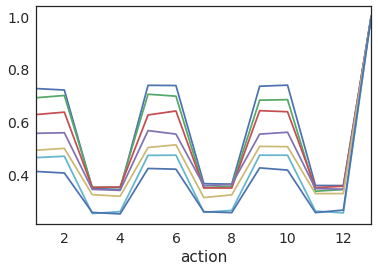

In [165]:
act_freq = cdf.groupby(['cost', 'action']).apply(len) / 5000
act_freq.reset_index().set_index('action').groupby('cost')[0].plot()

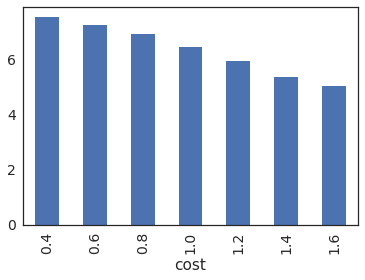

In [152]:
cdf.groupby(['cost', 'rep']).apply(len).mean(level=0).plot.bar()

In [297]:
def add_epsilon(pol, eps):
    old_act = pol.act

    def new_act(state):
        if np.random.rand() < eps:
            return np.random.choice(list(pol.env.actions(state)))
        else:
            return old_act(state)

    pol.act = new_act
    return pol


In [298]:
bf_pols = ind_mle.query('model == "best_first"').apply(
    lambda row: add_epsilon(SoftmaxPolicy(satisfruning(best_first,
                                          satisfice=row.satisfice,
                                          prune=row.prune),
                            temp=row.temp), eps=row.p_error), axis=1)

In [299]:
from toolz import partition, concat
env_groups = partition(5000//len(bf_pols), range(5000))
ind_df = pd.DataFrame(list(concat(simulate(pol, envs[list(eg)])
                                  for pol, eg in zip(bf_pols, env_groups))))

In [ ]:
envs = pd.Series([make_exp_env(EXPERIMENT) for _ in range(5000)])
df_optimal = pd.DataFrame(simulate(optimal_policy, envs))
from policies import SoftmaxPolicy
bf = agg_mle.query('model == "best_first"').iloc[0]
best_first_policy = SoftmaxPolicy(satisfruning(best_first, 
                                               satisfice=bf.satisfice,
                                               prune=bf.prune))
df_best_first = DataFrame(simulate(best_first_policy, envs))

## Compare Best-First and Optimal

## Term probability

In [302]:
def plot_term(df, name, full=False, **kws):
    df['unobserved'] = df.state.apply(lambda state: sum(hasattr(x, 'sample') for x in state))
    df['etr'] = pd.Categorical(df.state.apply(env.expected_term_reward), categories=path_values)
    df['term'] = df.action == 13
    df['observed'] = pd.Categorical(12 - df['unobserved'], range(13))
    if full:
        x = df.groupby(['etr', 'observed']).term.sum().reset_index()
        x.term /= x.term.sum()
        x.term = np.log(x.term.replace(0, np.nan))
    else:
        x = df.groupby(['etr', 'observed']).term.mean().reset_index()
    idx = pd.Index(sorted(path_values)[2:], name="etr")
    X = x.pivot('etr', 'observed', 'term').astype(float).reindex(idx)
    sns.heatmap(X, cmap='viridis', linewidths=1, **kws, ).invert_yaxis()
    plt.ylabel('')
    plt.xlabel('Number of Clicks Made')
    plt.title(name)

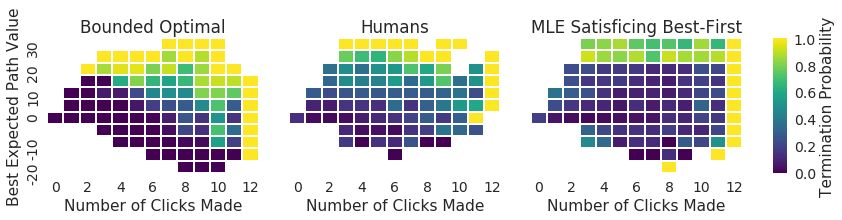

In [305]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3),
                         gridspec_kw={'width_ratios': [15, 15, 15, 1]})
plt.sca(axes[0])
plot_term(df_optimal, 'Bounded Optimal', cbar=False, )
plt.ylabel('Best Expected Path Value')

plt.sca(axes[1])
plot_term(data['unrolled'], 'Humans', cbar=False)
plt.yticks([])

plt.sca(axes[2])
plot_term(ind_df, 'MLE Satisficing Best-First', 
          cbar_kws=dict(label='Termination Probability'),
          cbar_ax=axes[3])
plt.yticks([])

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2)
# plt.gcf().subplots_adjust(left=.02)
# plt.gcf().subplots_adjust(right=-0.02)
# plt.savefig('../../paper/figures/termination.eps')

In [121]:
def best_best_first(row):
    pref = satisfruning(best_first, prune=row.prune, satisfice=row.satisfice)
    return SoftmaxPolicy(pref, temp=row.temp)
    
pid_bf_pols = ind_results.query('model == "best_first"').apply()

,temp,p_error,logp,satisfice,prune,model,k,N,bic,aic
pid,,,,,,,,,,
1,0.000010,0.25,-134.755975,5,-5,best_first,4,86,287.329339,277.511950
2,5.689866,0.15,-241.147806,25,-10,best_first,4,212,503.721956,490.295611
3,3.237458,0.24,-269.466787,25,-15,best_first,4,193,559.984335,546.933574
4,10.000000,0.25,-456.044214,20,-15,best_first,4,230,933.840746,920.088429
6,7.543120,0.11,-294.301327,25,-30,best_first,4,255,610.767707,596.602653
7,0.000010,0.25,-113.759389,5,-5,best_first,4,37,241.962451,235.518779
8,3.237458,0.25,-380.291110,10,-5,best_first,4,136,780.232840,768.582221
10,0.000010,0.25,-117.378093,5,-30,best_first,4,43,249.800986,242.756185
11,0.000010,0.25,-419.389270,5,-30,best_first,4,141,858.573579,846.778540


In [162]:
df['unobserved'] = df.state.apply(lambda state: sum(hasattr(x, 'sample') for x in state))
df['etr'] = pd.Categorical(df.state.apply(env.expected_term_reward), categories=path_values)
df['term'] = df.action == 13
df['observed'] = pd.Categorical(12 - df['unobserved'], range(13))
x = df.groupby(['etr', 'observed']).term.sum().reset_index()
x.term /= x.term.sum()
x.term = np.log(x.term.replace(0, np.nan))

In [309]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

ImportError: libicuuc.so.58: cannot open shared object file: No such file or directory

In [307]:
# select = list(pdf.query('best_model == "optimal" ').index)
rdf = data['unrolled'][['pid', 'term', 'etr', 'observed']]

In [308]:
%%R -i rdf
require(lme4)
m = glmer('term ~ etr * observed + (1|pid)', family='binomial', data=rdf)
print(m)
Anova(m)

[2018-05-12 14:28:08,616] Cell magic `%%R` not found.


## Action types

In [272]:
data['q'] = data.apply(lambda row: Q(row.state, row.action), 1)
data['v'] = data.state.apply(V)

df_best_first['q'] = df_best_first.apply(lambda row: Q(row.state, row.action), 1)
df_best_first['v'] = df_best_first.state.apply(V)

In [473]:
data.groupby('action_type').loss.sum()

action_type
click    -905.349476
term    -3908.228669
Name: loss, dtype: float64

In [481]:
print('Loss by action type')
print(l.groupby(level=0).agg([np.mean, np.std]))

Loss by action type
                  mean        std
action_type                      
click       -18.106990  14.839946
term        -72.837103  78.968698


In [548]:
g = data.groupby('action_type').loss
g.

In [560]:
l = (data.reset_index().set_index('pid').loc[pdf.n_clicks > 0]
     .groupby(['action_type', 'pid']).loss.sum().dropna())

In [562]:
l.click.index

Int64Index([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
            22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 39, 40, 42,
            45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61],
           dtype='int64', name='pid')

In [571]:
best_sat = ind_results.query('model == "best_first"').loc[l.click.index].satisfice

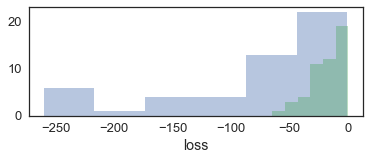

In [589]:
# for at, dd in l.groupby(level='action_type'):
fig = plt.figure(figsize=(6,2))
sns.distplot(l.term, label=at, kde=0)
sns.distplot(l.click, label=at, kde=0)
ax = plt.gca()

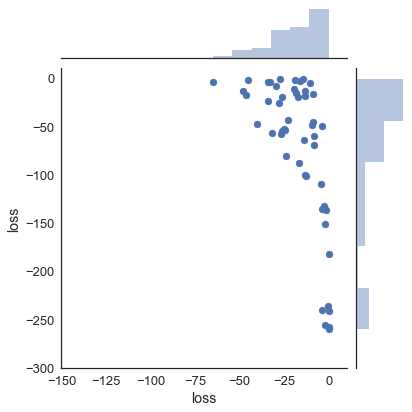

In [576]:
jp = sns.jointplot(l.click, l.term, stat_func=None,
                   xlim=(-150, 10), ylim=(-300, 10),
                   kind='scatter',
#                    joint_kws
#                    kind='kde', joint_kws=dict(shade=False)
                  )



# plt.plot(l.click, l.term, 'o')
# plt.xlabel('Click Loss')
# plt.ylabel('Term Loss')
# jp.ax_joint.set_xlim(-50, 0)
# jp.ax_joint.set_aspect('equal')

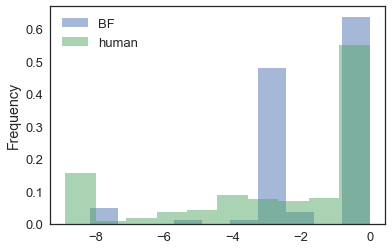

In [373]:
def action_type(action):
    if action == env.term_action:
        return 'term'
    else:
        return 'click'
        return len(env.path_to(action))

df_best_first.query('action_type == "term"').loss.plot.hist(
    alpha=0.5, normed=1, label='BF')
data.query('action_type == "term"').loss.plot.hist(
    alpha=0.5, ax=plt.gca(), normed=1, label='human')
plt.legend()
# for at, dd in data.groupby('action_type').loss:
#     ax = next(axes)
#     sns.distplot(dd, label=at, kde=0, ax=ax)

In [ ]:
data.groupby('action_type').loss.plot.hist

# View rollouts

In [49]:
df = tdf
df = df.rename(columns={'state_rewards': 'stateRewards'})
df = df[['pid', 'actions', 'clicks', 'stateRewards']]
df.to_json('../experiment/experiment/static/json/demo/312.json', orient='records')

In [20]:
row = tdf.iloc[0]
def write_demo(df):
    x = df.apply(lambda row: {'clicks': row.clicks, 'actions': row.actions})
row.clicks
row.actions

['left', 'left', 'up']

In [ ]:
np.random.seed(1)

import json
def demo(env):
    trace = run_episode(optimal_policy, env)
    
    return {
        'trial_id': hash(env),
        'stateRewards': list(map(round, env.ground_truth)),
        'demo': 
    }

nr_environments = 100  # 1000 -> 100
branch = [3,1,2]
env_type = ''.join(map(str, branch))
envs = [make_env(mu=0, sigma=6, quantization=4, branching=branch)
        for _ in range(nr_environments)]

fn = 'data/experiment_trials/'+env_type+'.json'
with open(fn, 'w+') as f:
    print('wrote', fn)
    json.dump(list(map(env_data, envs)), f)

In [ ]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)